## Model: user_product_mlp_BERT

* 将user和product（title和summary经过BERT预处理）分别过mlp层再concat再过mlp层

In [1]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 设置中文字体（以 SimHei 为例）
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 显示负号

import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate, Embedding, Flatten, RNN, Multiply, Dot,Reshape
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# 读取 Parquet 文件
df = pd.read_parquet('data_train.parquet')

title_bert = pd.read_parquet('title_embeded_df.parquet')
# 添加前缀
title_bert = title_bert.rename(columns=lambda x: f'title_{x}' if x != 'productId_encode' else x)

summary_bert = pd.read_parquet('summary_embeded_df.parquet')
# 添加前缀
summary_bert = summary_bert.rename(columns=lambda x: f'summary_{x}' if x != 'productId_encode' else x)


df = pd.merge(df,title_bert,on="productId_encode",how="left")
df = pd.merge(df,summary_bert,on="productId_encode",how="left")

# 显示 DataFrame
display(df)

column_names = df.columns.tolist()
print(column_names)

,title,score,index,categories_All Electronics,categories_Alternative Rock,categories_Amazon Instant Video,categories_Amazon MP3 Store,categories_Appliances,categories_Arts,categories_Automotive,...,summary_758,summary_759,summary_760,summary_761,summary_762,summary_763,summary_764,summary_765,summary_766,summary_767
0,"Fender 351 Premium Celluloid Guitar Picks, 12 ...",5.0,137013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.009015,-0.275263,-0.116428,-0.077796,-0.109762,-0.034640,-0.170375,-0.058895,0.120862,-0.178705
1,Invicta Men's 9310 Pro Diver Collection Swiss ...,5.0,153884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.173811,-0.152411,-0.192120,-0.141039,-0.130455,-0.108379,-0.314738,-0.136465,-0.001570,-0.148408
2,Avalon Pocket Watch-A-8619,1.0,162386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.294283,-0.515356,-0.117184,-0.035012,-0.145873,0.018044,-0.286470,-0.408893,-0.018276,-0.190117
3,Men's Wenger 72228 AquaGraph 1000m Diver's Wat...,4.0,181813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.017133,0.014169,-0.316357,-0.210016,0.019641,-0.077994,-0.179455,-0.293180,-0.060798,-0.071542
4,Bulova Men's 97F50 Diamond Accent Watch,5.0,182575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.167180,-0.031464,0.083062,-0.403185,-0.173374,-0.318253,-0.061192,-0.055593,0.188848,-0.321239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180270,Humes & Berg Enduro DR421BK 5 x 14 Inches Snar...,5.0,101224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.059488,-0.055187,0.212158,-0.402054,0.039371,-0.025657,-0.212562,-0.240651,-0.574357,-0.286414
180271,On Stage Classic Single-X Keyboard Stand,5.0,146113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.019392,-0.375419,0.070425,0.062329,-0.096949,0.111267,-0.222908,-0.154764,0.041645,-0.061393
180272,Protec Guitar Strap with Leather Ends and Pick...,5.0,149587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.021712,-0.391585,0.121331,-0.126125,-0.215371,0.053999,-0.250634,0.018984,0.023540,-0.163926
180273,DR Strings Rare - Phosphor Bronze AcousticHex ...,5.0,108740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.375413,-0.534668,-0.092103,0.031504,0.227732,0.096559,0.003258,-0.050956,-0.015066,-0.191119


['title', 'score', 'index', 'categories_All Electronics', 'categories_Alternative Rock', 'categories_Amazon Instant Video', 'categories_Amazon MP3 Store', 'categories_Appliances', 'categories_Arts', 'categories_Automotive', 'categories_Baby', 'categories_Baby Products', 'categories_Beauty', 'categories_Blues', 'categories_Books', 'categories_Camera & Photo', 'categories_Car Electronics', 'categories_Cell Phones & Accessories', 'categories_Classical', 'categories_Clothing & Accessories', 'categories_Collectibles', 'categories_Computers', 'categories_Country', 'categories_Dance & DJ', 'categories_Dance & Electronic', 'categories_Electronics', 'categories_Folk', 'categories_Furniture & D&#233;cor', 'categories_GPS & Navigation', 'categories_Gift Cards Store', 'categories_Gifts', 'categories_Grocery & Gourmet Food', 'categories_Hard Rock & Metal', 'categories_Health & Personal Care', 'categories_Home & Kitchen', 'categories_Home Improvement', 'categories_Industrial & Scientific', 'categori

In [3]:
# user variable
user_columns =  ['userId_encode']+ [elem for elem in column_names if elem.startswith('his_')]

# product variable (without text)
product_nontext_columns = ['productId_encode','train_mean_score','helpfulness_helpful','helpfulness_total']+[elem for elem in column_names if elem.startswith('categories_')]+[elem for elem in column_names if elem.startswith('brand_')]+ [f'title_{i}' for i in range(768)]+[f'summary_{i}' for i in range(768)]

# target
target_column = 'score'

In [4]:
X_user = df[user_columns].values
X_product_nontext = df[product_nontext_columns].values

In [5]:
input_user = Input(shape=(X_user.shape[1],))
input_product_nontext = Input(shape=(X_product_nontext.shape[1],))

# user MLP 层
x_user = Dense(64, activation='relu')(input_user)
x_user = BatchNormalization()(x_user)  # 添加Batch Normalization
x_user = Dropout(0.5)(x_user)  # 在全连接层后添加Dropout
x_user = Dense(32, activation='relu')(x_user)
x_user = BatchNormalization()(x_user)  # 添加Batch Normalization
x_user = Dropout(0.5)(x_user)  # 在全连接层后添加Dropout

# product nontext MLP 层
x_product_nontext = Dense(64, activation='relu')(input_product_nontext)
x_product_nontext = BatchNormalization()(x_product_nontext)  # 添加Batch Normalization
x_product_nontext = Dropout(0.5)(x_product_nontext)  # 在全连接层后添加Dropout
x_product_nontext = Dense(32, activation='relu')(x_product_nontext)
x_product_nontext = BatchNormalization()(x_product_nontext)  # 添加Batch Normalization
x_product_nontext = Dropout(0.5)(x_product_nontext)  # 在全连接层后添加Dropout

# 拼接
x = Concatenate()([x_user, x_product_nontext])

# MLP 层
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)  # 添加Batch Normalization
x = Dropout(0.5)(x)  # 在全连接层后添加Dropout
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)  # 添加Batch Normalization
x = Dropout(0.5)(x)  # 在全连接层后添加Dropout
x = Dense(32, activation='relu')(x)
output = Dense(1)(x)  # 输出层

# 构建模型
model = Model(inputs=[input_user,input_product_nontext], outputs=output)
model.summary()

# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit([X_user,X_product_nontext], df[target_column].values, epochs=50, batch_size=256, validation_split=0.2, callbacks=[early_stopping])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 73)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1612)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           4736        ['input_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 64)           103232      ['input_2[0][0]']                
                                                                                              

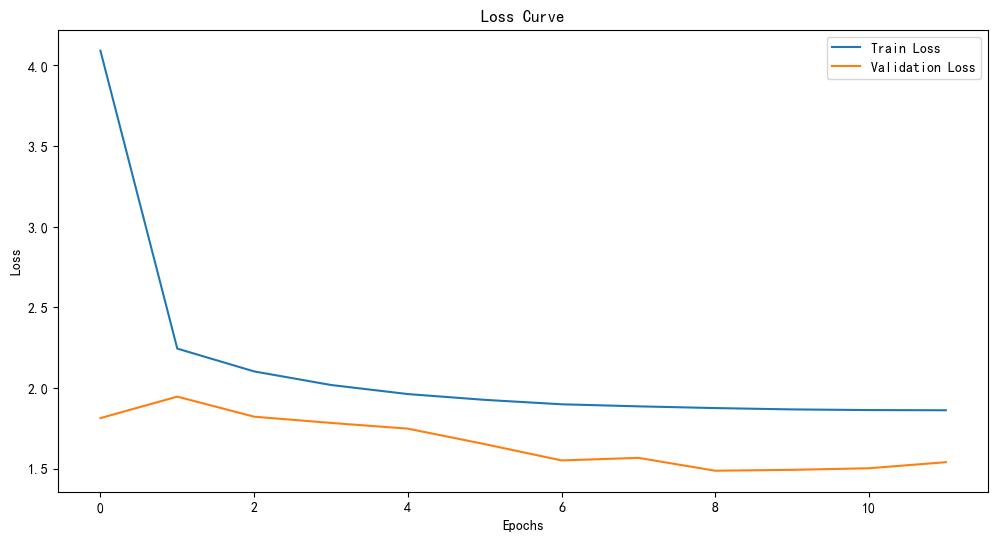

In [6]:
# 绘制损失曲线
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [7]:
model.save('user_product_mlp_BERT.h5')